# Final Project: Martian Landscape Images




## Introduction

HiRISE (High Resolution Imaging Science Experiment) is a Mars orbiter launched in 2006. Its mission objectives are to analyze possible landing sites for other crafts, provide data for geological studies, and to study climate and seasonal processes(McEwen, 2007). It also provides a public-facing website that can be used to explore land features and suggest possible imaging targets. Its data was normalized for the labeled data set used in this model as grayscale, 227x227 pixel images (NASA, 2025).

With more than 11,000 landmarks to analyze, sorting through the data manually would be a monumental task. In order to identify objects of interest to future projects on Mars, including landers and geological research, the images need to be reasonably filtered and analyzed. In this project, we attempt to perform the first step, sorting the normalized images from the provided data set into their labeled categories.

These present some unique challenges on their own. Although the quality of the images is relatively high, the nature of orbital imagery creates black artifacts at the corners of the images, and some of the labels provided are so broad that some manipulation of the data set is required to obtain a reasonable result when training a neural network.

### Previous Work
On a larger scale, this data set has been analyzed using deep learning to provide feedback on possible landing sites for Mars rovers, such as the NOAH-H project (Woods, 2020). NOAH used 14 classifiers to locate suitable landing sites based on the geological data found in HiRISE's images. It was able to classify different bedrock formations and possible hazards to landing craft; according to the original stated purpose of the orbiter, an outcropping or other object as small as 0.33 meters could present a serious risk to a lander (McEwan, 2010).
In 2010, McEwen et al. published a paper on the multitude of findings made by the Mars Reconnaissance Orbiter (MRO) team, such as evidence of groundwater flows, pyroclastic deposits, clay-rich deposits, early tectonic activity, and much more (McEwan, 2007). These discoveries were based on only 9137 images, a smaller number than the more than 11,000 landmarks identified in the HiRISE labeled dataset.

These studiesrepresent only a pair of samples of the incredible power of this data set for a variety of Mars research projects.

### Our Goal
Identifying and classifying images in a large dataset provides a useful tool for future research in this field. We will use a CNN to perform this task, using different techniques to preprocess the data and provide a model that will be able to quickly identify the images with the goal that individual classes could be chosen for other research projects.

## Dataset
Mars orbital image: HiRISE labeled data set, version 3 (NASA, 2025)

Total: 73031 pixel images
* 0 - Other: 61054
* 1 - Crater: 4900
* 2 - Dark Dune: 1141
* 3 - Slope Streak: 2331
* 4 - Bright Dune: 1750
* 5 - Impact Ejecta: 231
* 6 - Swiss Cheese: 1148
* 7 - Spider: **476**

As shown above, there are a significant number of pixels that are classified as "other." We will attempt to compensate for this imbalance in the data via different preprocessing methods, using a CNN model.

In [ ]:
#Opening Connection to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

Opening file. Originally, this was done using a Google drive, but it became much easier to manage using the Git repository directly.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch
from imageio import imread
import os

PYTORCH_CUDA_ALLOC_CONF=expandable_segments = True

In [ ]:
#Testing google drive connection
#!gdown --id 1qnYV5WyxdGnVdhbG_0FKX7HbodKBAO9B

In [ ]:
#Testing checking for nvidia
#!nvidia-smi

In [ ]:
#Pulling in file showing image names and labels

!wget "https://zenodo.org/records/2538136/files/hirise-map-proj-v3.zip?download=1" -O hirise.zip

!unzip -q hirise.zip -d hirise

--2025-05-13 00:22:07--  https://zenodo.org/records/2538136/files/hirise-map-proj-v3.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 985889206 (940M) [application/octet-stream]
Saving to: ‘hirise.zip’

hirise.zip          100%[===================>] 940.22M  19.2MB/s    in 52s     

2025-05-13 00:23:00 (18.0 MB/s) - ‘hirise.zip’ saved [985889206/985889206]

replace hirise/landmarks_map-proj-v3_classmap.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


This cell manages the images and lavels. Later, we will have to truncate the collection for the sake of processing time.

It is important to note that even with added processing time on Google CoLabs, we continuously ran out of RAM while running the notebook, and so we added sample_size, which randmly pulled out a selected number of images at random. With some experimentation, we found we could run 20000 samples.

In [ ]:
image_dir = 'hirise/map-proj-v3/'
labels_file = 'hirise/labels-map-proj-v3.txt'

df = pandas.read_csv(labels_file, header=None, delim_whitespace=True, na_values='?')
names =  ['ImageName', 'Label']
df.columns = names

all_images = []
all_labels = []

# Here is the number of samples we can process before running out of RAM:
sample_size = 20000

subset_df = df.sample(sample_size, random_state=42)

for _, row in subset_df.iterrows():
    file_path = os.path.join(image_dir, row.ImageName)
    try:
        img = np.array(imread(file_path))
        all_images.append(img)
        all_labels.append(int(row.Label))
    except FileNotFoundError:
        print(f"Missing: {file_path}")
        continue

df

<ipython-input-6-c1f6013b11a3>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pandas.read_csv(labels_file, header=None, delim_whitespace=True, na_values='?')
<ipython-input-6-c1f6013b11a3>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.array(imread(file_path))


,ImageName,Label
0,ESP_011623_2100_RED-0069.jpg,0
1,ESP_011623_2100_RED-0069-r90.jpg,0
2,ESP_011623_2100_RED-0069-r180.jpg,0
3,ESP_011623_2100_RED-0069-r270.jpg,0
4,ESP_011623_2100_RED-0069-fh.jpg,0
...,...,...
73026,PSP_010461_1845_RED-0032-r180.jpg,0
73027,PSP_010461_1845_RED-0032-r270.jpg,0
73028,PSP_010461_1845_RED-0032-fh.jpg,0
73029,PSP_010461_1845_RED-0032-fv.jpg,0


Here we can see the distribution of the actual classes. Just like the pixel count, label 0 ("other") is highly overrepresented.

In [ ]:
#Checking label numbers
value_counts = df['Label'].value_counts()
print(value_counts)

Label
0    61054
1     4900
3     2331
4     1750
6     1148
2     1141
7      476
5      231
Name: count, dtype: int64


In [ ]:
#change structure to be entirely numpy arrays
all_images = np.stack(all_images, axis=0)
all_labels = np.array(all_labels)
print(f"Final all_images shape: {all_images.shape}")
print(f"Final all_lables shape: {all_labels.shape}")


Final all_images shape: (20000, 227, 227)
Final all_lables shape: (20000,)


In [ ]:
#Adding another domention for the number of channels in images in this case 1
unique_labels, counts = np.unique(all_labels, return_counts=True)

result = dict(zip(unique_labels, counts))
print(result)

{np.int64(0): np.int64(16680), np.int64(1): np.int64(1348), np.int64(2): np.int64(320), np.int64(3): np.int64(647), np.int64(4): np.int64(478), np.int64(5): np.int64(65), np.int64(6): np.int64(313), np.int64(7): np.int64(149)}


In [ ]:
#Ensuring shape is as expected
all_images.shape

(20000, 227, 227)

## Base Model: No Changes
Attempt to run the model on the raw data and obtain a baseline performance.

In [ ]:
#CNN
#Taken From Assignment 5
class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)

        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []
        loss_history = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0


            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss.item()

            self.error_trace.append(loss_sum / num_batches)
            avg_loss = loss_sum / num_batches
            loss_history.append(avg_loss)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return loss_history

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [ ]:
#After setting the Colab to run GPU ensure it recongnizes that
print("Is CUDA available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

Is CUDA available: True
GPU Device: NVIDIA A100-SXM4-40GB


In [ ]:
#Splitting data set into train and test
unfiltered_images = np.expand_dims(all_images, axis=1)
print(unfiltered_images.shape)

(20000, 1, 227, 227)


In [ ]:
trainSet = unfiltered_images[0:int(0.8*len(all_labels)),:,:,:]
trainLabels = all_labels[0:int(0.8*len(all_labels))]

testSet = unfiltered_images[int(0.8*len(all_labels)):,:,:,:]
testLabels = all_labels[int(0.8*len(all_labels)):]
trainSet.shape

(16000, 1, 227, 227)

In [ ]:
n_hiddens_per_conv_layer = [64]
patch_size_per_conv_layer = [7]
stride_per_conv_layer=[4]
n_hiddens_per_fc_layer = [128]

cnnet = CNN2D(227 * 227, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(trainLabels)),
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 100
batch_size = 64
learning_rate = 0.001

loss_history = cnnet.train(trainSet, trainLabels, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.688
adam: Epoch 20 Loss 0.679
adam: Epoch 30 Loss 0.683
adam: Epoch 40 Loss 0.675
adam: Epoch 50 Loss 0.669
adam: Epoch 60 Loss 0.671
adam: Epoch 70 Loss 0.670
adam: Epoch 80 Loss 0.664
adam: Epoch 90 Loss 0.671
adam: Epoch 100 Loss 0.661


### Results: Base Model

With some tweaking to the base model, we managed to get a performance around 83-84% accuracy. We theorized this could be due to the overrepresentation of class 0 both in labels and individual pixels. The chances that the model would train almost entirely on class 0 was moderately high.

Loss history length: 100
First 10 losses: [0.7254981545209884, 0.6836670023202897, 0.7054912983179092, 0.6787444368600846, 0.6820625659227372, 0.6795970432758331, 0.6927017180919647, 0.6904812645912171, 0.6956628460884094, 0.6883057668209076]


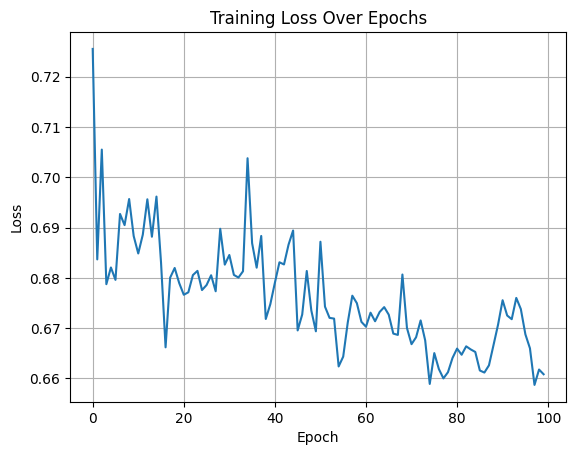

In [ ]:
print("Loss history length:", len(loss_history))
print("First 10 losses:", loss_history[:10])

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
#Checking accuracy
Ytrain, _ = cnnet.use(trainSet)
Ytest, _ = cnnet.use(testSet)
perc_correct_train = 100 * np.mean(Ytrain == trainLabels)
print(f'Train accuracy in percent correct: {perc_correct_train:.2f}')
perc_correct_test = 100 * np.mean(Ytest == testLabels)
print(f'Test accuracy in percent correct: {perc_correct_test:.2f}')

Train accuracy in percent correct: 83.34
Test accuracy in percent correct: 83.62


## Preprocessing
### Issues to address
<p>
* Unevenly distributed dataset
<br>Possible solutions:
<br>Exclude data (particularly class 0)
<br>Selective bootstrapping
</p>

## Solution 1: Exclude Data (Class 0)

Our first experiment was to eliminate class 0 from the model. Since all of these items were "other" and not necessarily as useful as identifying specific landmarks, this seemed like a reasonable approach.

In [ ]:
#removing all of the images labeled 0(other) from the dataset
filtered_data = [(label, image) for label, image in zip(all_labels, all_images) if label != 0]

In [ ]:
new_labels = np.array([label for label, image in filtered_data])
new_images = np.array([image for label, image in filtered_data])
print("Labels shape:", new_labels.shape)
print("Images shape:", new_images.shape)

Labels shape: (3320,)
Images shape: (3320, 227, 227)


In [ ]:
#shuffle both the image order and the label order but use same shuffle so images and lables are still aligned
shuffled_indices = np.random.permutation(len(new_labels))

shuffled_images = new_images[shuffled_indices]
shuffled_labels = new_labels[shuffled_indices]

print("Shuffled Images Shape:", shuffled_images.shape)
print("Shuffled Labels Shape:", shuffled_labels.shape)

Shuffled Images Shape: (3320, 227, 227)
Shuffled Labels Shape: (3320,)


In [ ]:
#Splitting data set into train and test
reshaped_images = np.expand_dims(shuffled_images, axis=1)
print(reshaped_images.shape)

(3320, 1, 227, 227)


In [ ]:
#After setting the Colab to run GPU ensure it recongnizes that
print("Is CUDA available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

Is CUDA available: True
GPU Device: NVIDIA A100-SXM4-40GB


In [ ]:
trainSet = reshaped_images[0:int(0.8*len(shuffled_labels)),:,:,:]
trainLabels = shuffled_labels[0:int(0.8*len(shuffled_labels))]

testSet = reshaped_images[int(0.8*len(shuffled_labels)):,:,:,:]
testLabels = shuffled_labels[int(0.8*len(shuffled_labels)):]
trainSet.shape

(2656, 1, 227, 227)

In [ ]:
#Small run to see if it can make it through the model
n_hiddens_per_conv_layer = [64]
patch_size_per_conv_layer = [7]
stride_per_conv_layer=[4]
n_hiddens_per_fc_layer = [128]

cnnetRmv0 = CNN2D(227 * 227, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(trainLabels)),
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 50
batch_size = 32
learning_rate = 0.001

loss_history = cnnetRmv0.train(trainSet, trainLabels, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 5 Loss 0.727
adam: Epoch 10 Loss 0.727
adam: Epoch 15 Loss 0.727
adam: Epoch 20 Loss 0.727
adam: Epoch 25 Loss 0.727
adam: Epoch 30 Loss 0.727
adam: Epoch 35 Loss 0.727
adam: Epoch 40 Loss 0.727
adam: Epoch 45 Loss 0.727
adam: Epoch 50 Loss 0.727


### Results: Remove Class 0

Loss history length: 50
First 10 losses: [0.7323636309504509, 0.7273103905022145, 0.7273329041004181, 0.7273411068022251, 0.7273449003696442, 0.7273468488156796, 0.7273478938043118, 0.7273484759628773, 0.727348824441433, 0.7273490037322045]


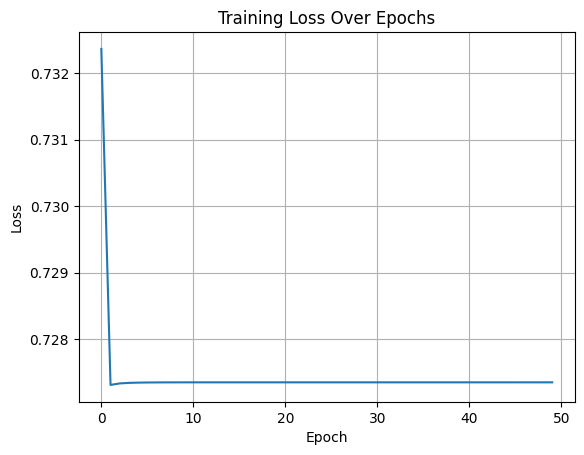

In [ ]:
print("Loss history length:", len(loss_history))
print("First 10 losses:", loss_history[:10])

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
#Checking accuracy
Ytrain, _ = cnnet.use(trainSet)
Ytest, _ = cnnet.use(testSet)
perc_correct_train = 100 * np.mean(Ytrain == trainLabels)
print(f'Train accuracy in percent correct: {perc_correct_train:.2f}')
perc_correct_test = 100 * np.mean(Ytest == testLabels)
print(f'Test accuracy in percent correct: {perc_correct_test:.2f}')

Train accuracy in percent correct: 83.40
Test accuracy in percent correct: 83.40


In [ ]:
#checking which labels it is able to identify and which not
train_accurate = []
train_inaccurate_output = []
train_inaccurate_label = []
for index in range(len(trainLabels)):
  if Ytrain[index] == trainLabels[index]:
    train_accurate.append(Ytrain[index])
  else:
    train_inaccurate_output.append(Ytrain[index])
    train_inaccurate_label.append(trainLabels[index])

In [ ]:
unique_labels, counts = np.unique(train_accurate, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{}


In [ ]:
unique_labels, counts = np.unique(train_inaccurate_output, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{np.int64(0): np.int64(2656)}


In [ ]:
unique_labels, counts = np.unique(train_inaccurate_label, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{np.int64(1): np.int64(1087), np.int64(2): np.int64(264), np.int64(3): np.int64(504), np.int64(4): np.int64(380), np.int64(5): np.int64(54), np.int64(6): np.int64(240), np.int64(7): np.int64(127)}


In [ ]:
test_accurate = []
test_inaccurate_output = []
test_inaccurate_label = []
for index in range(len(testLabels)):
  if Ytest[index] == testLabels[index]:
    test_accurate.append(Ytest[index])
  else:
    test_inaccurate_output.append(Ytrain[index])
    test_inaccurate_label.append(trainLabels[index])

In [ ]:
unique_labels, counts = np.unique(test_accurate, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{}


In [ ]:
unique_labels, counts = np.unique(test_inaccurate_output, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{np.int64(0): np.int64(664)}


In [ ]:
unique_labels, counts = np.unique(test_inaccurate_label, return_counts=True)
result = dict(zip(unique_labels, counts))
print(result)

{np.int64(1): np.int64(264), np.int64(2): np.int64(72), np.int64(3): np.int64(125), np.int64(4): np.int64(95), np.int64(5): np.int64(14), np.int64(6): np.int64(56), np.int64(7): np.int64(38)}


Some versions of this model produced exactly the same accuracy as the base model, meaning the model was training only on class 0. Changing any parameters actually brought accuracy down to 0%!

In theory, the model is still searching for class 0, or else without the class 0 images, it does not have enough data to train at all. We noticed the largest difference happened when we switched to using only a part of the dataset, but because of the requirements of the entire notebook, we were unable to continue running this model on the entire dataset.

## Solution 2: Stratified K-Fold

This is a module that is provided as part of SciKit. It should select a relative amount from each class, so even though class 0 is overrepresented, this will guarantee that every class at least has some presence in each k-fold. Because it retains relative numbers, class 0 will still be the largest part of each fold.

In [ ]:
from sklearn.model_selection import StratifiedKFold

shuffled_images, all_labels = [], []
for _, row in subset_df.iterrows():
    shuffled_images.append(img)
    all_labels.append(int(row.Label))

shuffled_images = np.stack(shuffled_images)
reshaped_images = np.expand_dims(shuffled_images, axis=1)
all_labels = np.array(all_labels)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\n--- Fold {fold_idx + 1} ---")

    trainSet = reshaped_images[train_idx]
    trainLabels = all_labels[train_idx]
    testSet = reshaped_images[test_idx]
    testLabels = all_labels[test_idx]

    # Create and train a model on this fold
    cnnetSKF = CNN2D(227 * 227, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(trainLabels)),
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

    loss_history = cnnetSKF.train(trainSet, trainLabels, batch_size, n_epochs=10, learning_rate=0.0005, method='adam')



--- Fold 1 ---
adam: Epoch 1 Loss 0.733
adam: Epoch 2 Loss 0.723
adam: Epoch 3 Loss 0.723
adam: Epoch 4 Loss 0.723
adam: Epoch 5 Loss 0.723
adam: Epoch 6 Loss 0.724
adam: Epoch 7 Loss 0.724
adam: Epoch 8 Loss 0.724
adam: Epoch 9 Loss 0.724
adam: Epoch 10 Loss 0.724

--- Fold 2 ---
adam: Epoch 1 Loss 0.736
adam: Epoch 2 Loss 0.724
adam: Epoch 3 Loss 0.724
adam: Epoch 4 Loss 0.724
adam: Epoch 5 Loss 0.724
adam: Epoch 6 Loss 0.724
adam: Epoch 7 Loss 0.724
adam: Epoch 8 Loss 0.724
adam: Epoch 9 Loss 0.724
adam: Epoch 10 Loss 0.724

--- Fold 3 ---
adam: Epoch 1 Loss 0.728
adam: Epoch 2 Loss 0.723
adam: Epoch 3 Loss 0.723
adam: Epoch 4 Loss 0.723
adam: Epoch 5 Loss 0.723
adam: Epoch 6 Loss 0.723
adam: Epoch 7 Loss 0.723
adam: Epoch 8 Loss 0.723
adam: Epoch 9 Loss 0.723
adam: Epoch 10 Loss 0.723

--- Fold 4 ---
adam: Epoch 1 Loss 0.730
adam: Epoch 2 Loss 0.724
adam: Epoch 3 Loss 0.724
adam: Epoch 4 Loss 0.724
adam: Epoch 5 Loss 0.724
adam: Epoch 6 Loss 0.724
adam: Epoch 7 Loss 0.724
adam: Ep

Loss history length: 10
First 10 losses: [0.7269306791126728, 0.7237207901775837, 0.7237221765816212, 0.7237227104008198, 0.7237229499816894, 0.723723091006279, 0.7237231605350971, 0.7237231990098953, 0.7237232254743576, 0.7237232269346714]


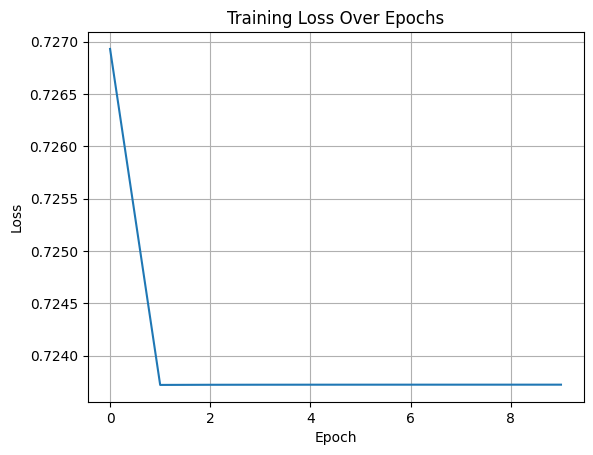

In [ ]:
print("Loss history length:", len(loss_history))
print("First 10 losses:", loss_history[:10])

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
#Checking accuracy
Ytrain, _ = cnnet.use(trainSet)
Ytest, _ = cnnet.use(testSet)
perc_correct_train = 100 * np.mean(Ytrain == trainLabels)
print(f'Train accuracy in percent correct: {perc_correct_train:.2f}')
perc_correct_test = 100 * np.mean(Ytest == testLabels)
print(f'Test accuracy in percent correct: {perc_correct_test:.2f}')

Train accuracy in percent correct: 83.40
Test accuracy in percent correct: 83.40


The sharp decline in the training loss makes us believe that the model is training efficiently, but it still seems to not compensate for the class imbalance.

Because class 0 will still be overrepresented in the data, we can assume the model is still overfitting largely to class 0 and failing to accurately identify other classes.

## Problem: Black Edges

The most obvious solution is to greyscale large black areas. There is some risk that this module will catch other black features within the pictures, but it is designed to smooth out the large, trangular black artifacts, so that they will read more like the rest of the gray background behind the landscape features we are insterested in training the model on.

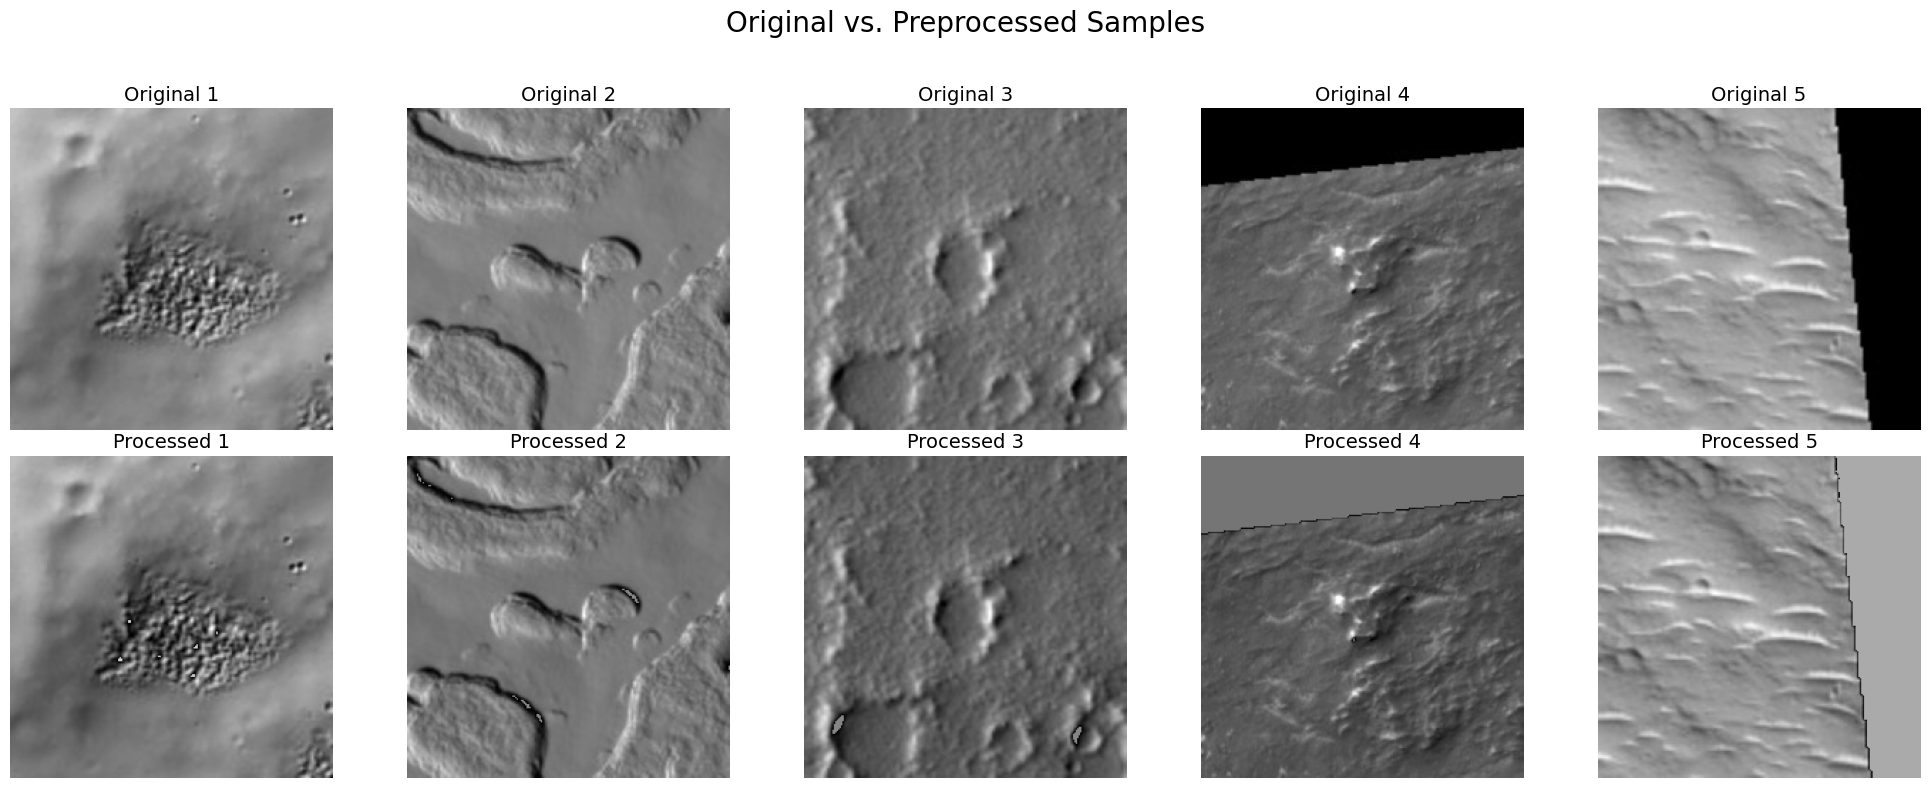

In [ ]:
from PIL import Image

def preprocess(image_array, darkness_threshold=20):
  # Masking
  img_array = np.array(image_array)
  mask = img_array < darkness_threshold
  img_array[mask] = 128
  img_array = img_array / 255.0

  return img_array

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle("Original vs. Preprocessed Samples", fontsize=20)

# Test preprocess
for i in range(5):
  orig = all_images[i]
  proc = preprocess(all_images[i])

  # Top row: original
  axes[0, i].imshow(orig, cmap='gray')
  axes[0, i].set_title(f"Original {i+1}", fontsize=14)
  axes[0, i].axis('off')

  # Bottom row: preprocessed
  axes[1, i].imshow(proc, cmap='gray')
  axes[1, i].set_title(f"Processed {i+1}", fontsize=14)
  axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
trainSetMask = np.array([preprocess(img) for img in trainSet])
testSetMask = np.array([preprocess(img) for img in testSet])

n_hiddens_per_conv_layer = [64]
patch_size_per_conv_layer = [7]
stride_per_conv_layer=[4]
n_hiddens_per_fc_layer = [128]

cnnetMask = CNN2D(227 * 227, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(trainLabels)),
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 100
batch_size = 128
learning_rate = 0.001

loss_history = cnnetMask.train(trainSetMask, trainLabels, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.723
adam: Epoch 20 Loss 0.723
adam: Epoch 30 Loss 0.723
adam: Epoch 40 Loss 0.723
adam: Epoch 50 Loss 0.723
adam: Epoch 60 Loss 0.723
adam: Epoch 70 Loss 0.723
adam: Epoch 80 Loss 0.723
adam: Epoch 90 Loss 0.723
adam: Epoch 100 Loss 0.723


### Results: Masking

Loss history length: 100
First 10 losses: [0.7505373620986938, 0.7226712231636048, 0.7228296959400177, 0.7228980362415314, 0.7229363529682159, 0.7229606637954712, 0.7229772558212281, 0.7229891302585602, 0.7229979565143585, 0.7230047175884247]


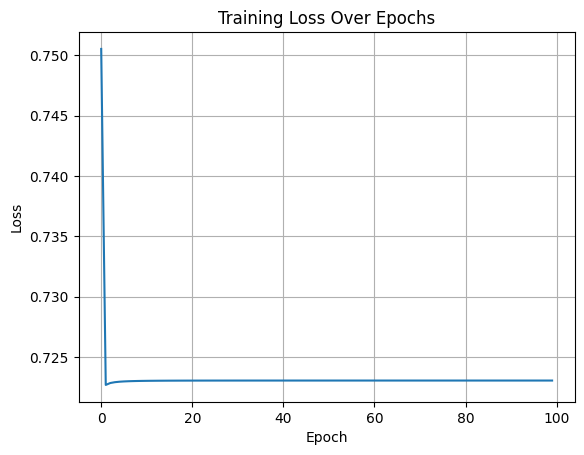

In [ ]:
print("Loss history length:", len(loss_history))
print("First 10 losses:", loss_history[:10])

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
#Checking accuracy
Ytrain, _ = cnnet.use(trainSetMask)
Ytest, _ = cnnet.use(testSetMask)
perc_correct_train = 100 * np.mean(Ytrain == trainLabels)
print(f'Train accuracy in percent correct: {perc_correct_train:.2f}')
perc_correct_test = 100 * np.mean(Ytest == testLabels)
print(f'Test accuracy in percent correct: {perc_correct_test:.2f}')

Train accuracy in percent correct: 83.40
Test accuracy in percent correct: 83.40


The similar results here means the black edges are probably not having a serious effect on the model. While the concern was that the model might start identifying those black regions with one class or another, it is difficult to see any effect on the overall class identification.

# Results

We worked to find automated solutions to the imbalanced dataset. We attempted three such solutions but never managed to find any one of them that had a dramatic effect on the overall data.

### Technical Considerations
Because of the size of the dataset, we used a subscription to GoogleCoLab to expand our RAM access, but even with this, we were still restricted to a smaller subsection of the data. By running the notebook multiple times, we could get a different random selection, but it still meant risking that the class imbalance grew within the subset of data.

### The Base Model
The base model performed with a barely acceptable rate of 83-84% accuracy, which could easily represent identifying every object as class 0 (inaccurately identifying 16-17% of the images).

### Manipulating the Data
Removing class 0 had virtually no effect on the model when running on the entire dataset, and it completely dismantled training when run on a data subset. Similarly, using Stratified K-Fold and image preprocessing returned very similar results to the base model. Each of these suggests that they are not overcoming the data imbalance and thus having only minor effects (if any) on data training.

### Future Work
With larger RAM capacity, the model would perform better if run on the entire dataset. In this case, the class imbalance might fall away naturally, or else one or more combination of the techniques outlined above might have a larger effect on performance.

Further work might also include combining the techniques and testing them, as well as using more standard methods like k-folding without selecting any subsets.



# References
McEwen, A. S., Banks, M. E., Baugh, N., Becker, K., Boyd, A., Bergstrom, J. W., Beyer, R. A., Bortolini, E., Bridges, N. T., Byrne, S., Castalia, B., Chuang, F. C., Crumpler, L. S., Daubar, I., Davatzes, A. K., Deardorff, D. G., DeJong, A., Delamere, W. A., Nobre, D., Dundas, C. M., Eliason, E. M., Espinoza, Y., Fishbaugh, K. E., Forrester, T., Geissler, P. E., Grant, J. A., Griffes, J. L., Grotzinger, J. P., Gulick, V. C., Hansen, C. J., Herkenhoff, K. E., Heyd, R., Jaeger, W. L., Jones, D., Keszthelyi, B. K., King, R., Kirk, R. L., Kolb, K. J., Lasco, J. E., Lefort, A., Leis, R., Lewis, K. W., Martinez-Alonso, S., Mattson, S., McArthur, G., Mellon, M. T., Metz, J. M., Milazzo, M. P., Milliken, R. E., Motazedian, T., Okubo, C. H., Ortiz, A. D., Philippoff, A., Polit, A., Russell, P. S., Schaller, C., Searls, M. L., Spriggs, T., Squyres, S. W., Tarr, S., Thomas, N., Thomson, B. J., Tornabene, L. V., Van Houten, C., Verba, C., Weitz, C. M., & Wray, J. J. (2010). The High Resolution Imaging Science Experiment (HiRISE) during MRO’s Primary Science Phase (PSP). Icarus, 205(1), 2–37. https://doi.org/10.1016/j.icarus.2009.04.023

McEwen, A. S., Eliason, E. M., Bergstrom, J. W., Bridges, N. T., Hansen, C. J., Delamere, W. A., Grant, J. A., Gulick, V. C., Herkenhoff, K. E., & Keszthelyi, L. P. (2007). Mars reconnaissance orbiter’s high resolution imaging science experiment (HiRISE). Journal of Geophysical Research: Planets, 112(E5). https://doi.org/10.1029/2005JE002605

NASA. (2025). Mars orbital image (HiRISE) labeled dataset version 3 [Data set]. https://data.nasa.gov/dataset/mars-orbital-image-hirise-labeled-data-set-version-3

Woods, M., Karachalios, S., Petrocelli, D., Barrett, A., Balme, M., & Joubert, N. (2020). NOAH-H: Automatic classification of HiRISE images using deep learning applied to ExoMars landing site selection support and future Mars Rover operations. In I-SAIRAS Virtual Conference (Vol. 8)